# Group 15: William Liu, Guillaume Miao, Jessica Wang

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

SEED = 42

# Task 1: Linear Regression with Non-Linear Basis Functions

Data generation

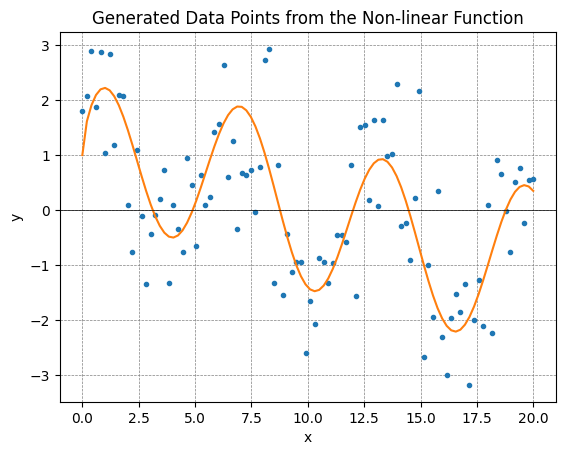

In [6]:
N = 100
x = np.linspace(0, 20, N)
yt = np.sin(np.sqrt(x)) + np.cos(x) + np.sin(x)
y = yt + np.random.randn(N)

plt.plot(x, y, '.')
plt.plot(x, yt)
plt.title('Generated Data Points from the Non-linear Function')
plt.xlabel('x')
plt.ylabel('y')
plt.axhline(0, color='black', linewidth=0.5, linestyle='-')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

Linear Regression and Gaussian Linear Regression classes

In [7]:
class LinearRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        self.w = None

    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]  # Add a dimension for the features
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x, np.ones(N)])  # Add bias by adding a constant feature of value 1
        self.w = np.linalg.lstsq(x, y, rcond=None)[0]  # Return w for the least square difference
        return self

    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x, np.ones(N)])
        yh = x @ self.w  # Predict the y values
        return yh

class GaussianBasisLinearRegression(LinearRegression):
    def __init__(self, D):
        super().__init__(add_bias=True)
        self.D = D  # Number of Gaussian bases
        self.mus = None  # Means for the Gaussian bases

    def gaussian_basis(self, x, mu, sigma=1):
        return np.exp(-((x - mu) ** 2) / (sigma ** 2))

    def fit(self, x, y):
        # Set means for Gaussian bases
        self.mus = np.linspace(min(x), max(x), self.D)

        # Construct the design matrix with Gaussian basis functions
        phi = np.array([self.gaussian_basis(x, mu) for mu in self.mus]).T

        # Use the fit method from LinearRegression
        super().fit(phi, y)

        return self

    def predict(self, x):
        # Construct the design matrix for prediction
        phi = np.array([self.gaussian_basis(x, mu) for mu in self.mus]).T

        # Use the predict method from LinearRegression
        return super().predict(phi)

Model fitting

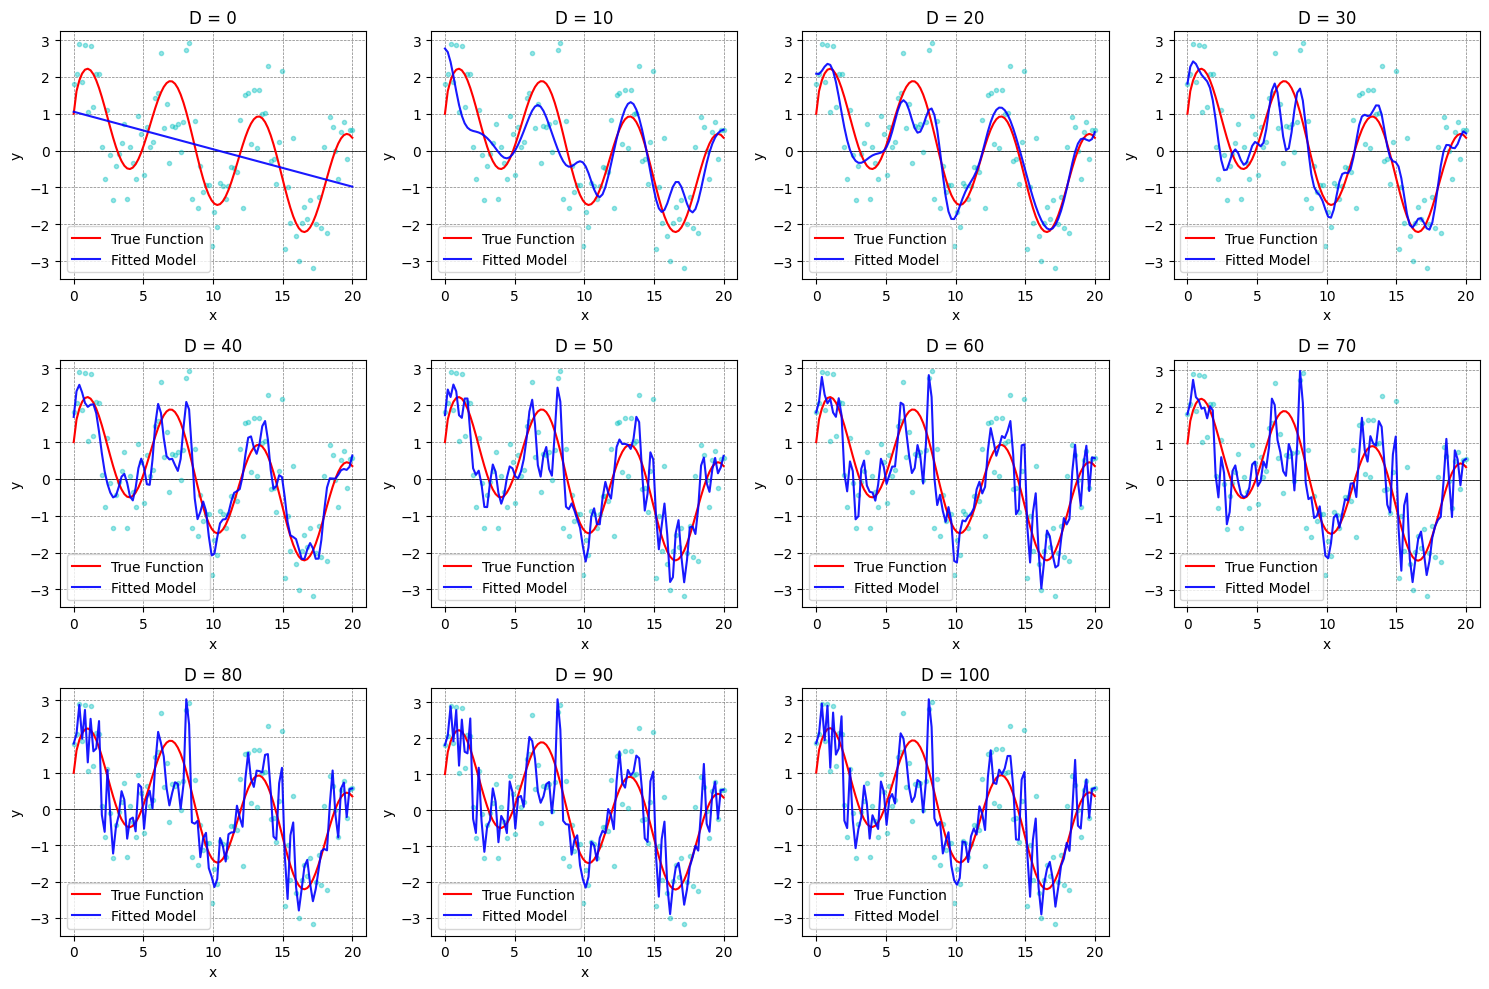

In [8]:
D = range(0, 101, 10)
plt.figure(figsize=(15, 10))

for i, d in enumerate(D):
    if d == 0:
        model = LinearRegression()
    else:
      model = GaussianBasisLinearRegression(D = d)
    yh = model.fit(x,y).predict(x)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.subplot(3, 4, i + 1)
    plt.axhline(0, color='black', linewidth=0.5, linestyle='-')
    plt.grid(color='gray', linestyle='--', linewidth=0.5)

    plt.plot(x, y, '.', color='c', alpha=0.4)
    plt.plot(x, yt, label='True Function', color = 'r')
    plt.plot(np.sort(x), yh[np.argsort(x)], label='Fitted Model', color='b', alpha = 0.9)
    plt.title(f'D = {d}')
    plt.legend()
plt.tight_layout()
plt.show()

Model selection

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=SEED)

SSE_train = []
SSE_val = []

D = range(0,101,10)
for d in D:
    if d == 0:
      model = LinearRegression()
    else:
      model = GaussianBasisLinearRegression(D = d)

    model.fit(x_train, y_train)
    yh_train = model.predict(x_train)
    SSE_train.append(np.sum((y_train - yh_train)**2))
    yh_val = model.predict(x_val)
    SSE_val.append(np.sum((y_val - yh_val)**2))

optimal_D_idx = np.argmin(SSE_val)
print(f'the optimal number of bases that minimizes the validation SSE is {optimal_D_idx*10}')

SSE_df = pd.DataFrame({
    'D': D,
    'Training_SSE': SSE_train,
    'Validation_SSE': SSE_val
})
print(SSE_df)

the optimal number of bases that minimizes the validation SSE is 10
      D  Training_SSE  Validation_SSE
0     0    139.645599    3.455102e+01
1    10     92.890192    1.813165e+01
2    20     57.565846    2.598052e+01
3    30     50.047125    2.687090e+01
4    40     44.184488    2.944701e+01
5    50     29.632610    2.235894e+02
6    60     16.885836    2.278641e+03
7    70      6.300601    2.681888e+04
8    80      4.967343    1.645144e+06
9    90      4.884080    1.035508e+07
10  100      4.674564    1.082137e+08


The attached results show how the model's performance changes with different numbers of Gaussian basis functions. Here's a detailed analysis:

### Observations:

1. **Underfitting**:
   - With very few basis functions, both the training and validation SSE are high. This indicates underfitting, where the model is too simple to capture the underlying pattern in the data.

2. **Optimal Fit**:
   - As the number of basis functions increases, the training SSE decreases, and the validation SSE initially decreases as well. At D = 20, the validation SSE is minimized, suggesting that this is the optimal number of basis functions for capturing the data pattern without overfitting.

3. **Overfitting**:
   - Beyond D = 20, although the training SSE continues to decrease, the validation SSE starts to increase significantly. This indicates overfitting, where the model becomes too complex and starts capturing noise in the training data rather than the true underlying pattern.

### Role of Validation Set:

- The validation set is crucial for identifying overfitting. While the training SSE alone might suggest that increasing complexity always improves performance (as it keeps decreasing), the validation SSE reveals when additional complexity starts to harm generalization to unseen data.
- By monitoring validation SSE, we can select the model with the best generalization ability, which in this case is at D = 20

### Conclusion:

The transition from underfitting to overfitting is effectively managed by evaluating both training and validation errors. The validation set helps determine the optimal model complexity that balances fitting accuracy with generalization capability.


Playing around with Sigmoid bases

In [56]:
class SigmoidBasisLinearRegression(LinearRegression):
    def __init__(self, D, regularization=None, alpha=1.0):
        super().__init__(add_bias=True, regularization=regularization, alpha=alpha)
        self.D = D
        self.mus = None

    def sigmoid(self, x, mu, sigma=1):
        return 1 / (1 + np.exp(-((x - mu) / sigma)))

    def fit(self, x, y):
        self.mus = np.linspace(0, 20, self.D)
        sigma = 1  # Standard deviation (spread) for the sigmoid
        phi = self.sigmoid(x[:, None], self.mus[None, :], sigma)
        super().fit(phi, y)
        return self

    def predict(self, x):
        sigma = 1  # Standard deviation (spread) for the sigmoid
        phi = self.sigmoid(x[:, None], self.mus[None, :], sigma)
        return super().predict(phi)

Sigmoid MSE:  0.8471627997947132
Gaussian MSE:  1.6654524080629705


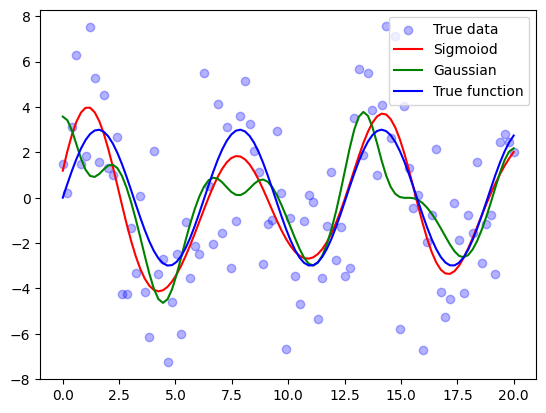

In [57]:
from sklearn.metrics import mean_squared_error
def run_sigmoid_basis_regression():
    np.random.seed(42)
    x = np.linspace(0, 20, 100)
    y = 3 * np.sin(x) + np.random.normal(0, 3, 100)  # Some non-linear relationship
    yf = 3 * np.sin(x)

    # Initialize and train the model
    model1 = SigmoidBasisLinearRegression(D=10, alpha=0.1)
    model1.fit(x, y)

    model2 = GaussianBasisLinearRegression(D=10, alpha=0.1)
    model2.fit(x, y)

    y_pred1 = model1.predict(x)
    y_pred2 = model2.predict(x)

    print("Sigmoid MSE: ", mean_squared_error(yf, y_pred1))
    print("Gaussian MSE: ", mean_squared_error(yf, y_pred2))

    plt.scatter(x, y, label='True data', color='blue', alpha = 0.3)
    plt.plot(x, y_pred1, label='Sigmoiod', color='red')
    plt.plot(x, y_pred2, label='Gaussian', color='green')
    plt.plot(x, yf, label = 'True function', color = 'blue')
    plt.legend()
    plt.show()

run_sigmoid_basis_regression()

# Task 2: Bias-Variance Tradeoff with Multiple Fits

Repeating task 1 and plotting multiple fits.

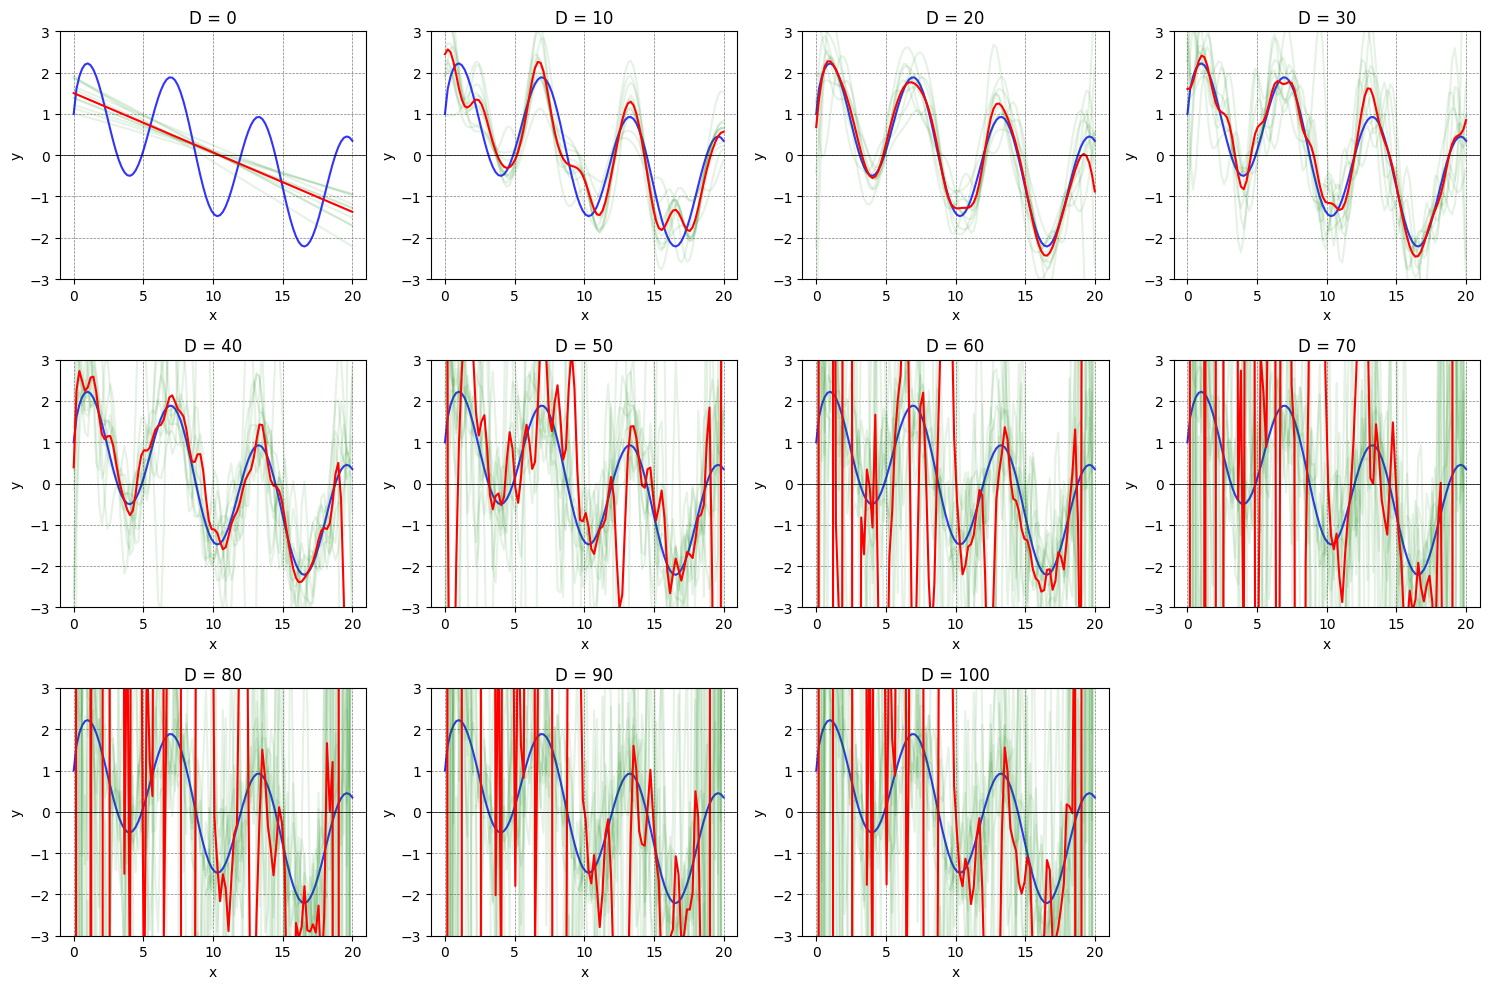

In [10]:
def generate_data(n_points):
    x = np.random.uniform(0, 20, n_points)
    epsilon = np.random.normal(0, 1, n_points)
    y = np.sin(np.sqrt(x)) + np.cos(x) + np.sin(x) + epsilon
    return x, y

n_reps = 10
N = 100
D = range(0, 101, 10)
models = {d: [] for d in D}

for rep in range(n_reps):
    x, y = generate_data(N)

    for d in D:
        if d == 0:
            model = LinearRegression()
        else:
            model = GaussianBasisLinearRegression(D = d)

        model.fit(x, y)
        models[d].append(model.predict(np.linspace(0, 20, N)))

x_plot = np.linspace(0, 20, N)
yt = np.sin(np.sqrt(x_plot)) + np.cos(x_plot) + np.sin(x_plot)
plt.figure(figsize=(15, 10))
for i, d in enumerate(D):
    plt.subplot(3, 4, i + 1)

    # Plot the true underlying distribution
    plt.plot(x_plot, yt, color='b', label='True Function', alpha=0.8)

    # Plot all model fits for a specific D in green
    for fit in models[d]:
        plt.plot(x_plot, fit, color='g', alpha=0.1)

    # Plot the average of the fitted models in red
    avg_fit = np.mean(models[d], axis=0)
    plt.plot(x_plot, avg_fit, color='r', label='Average Fit')

    plt.axhline(0, color='black', linewidth=0.5, linestyle='-')
    plt.title(f'D = {d}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.ylim(-3,3)

plt.tight_layout()
plt.show()


Plotting training and testing errors.



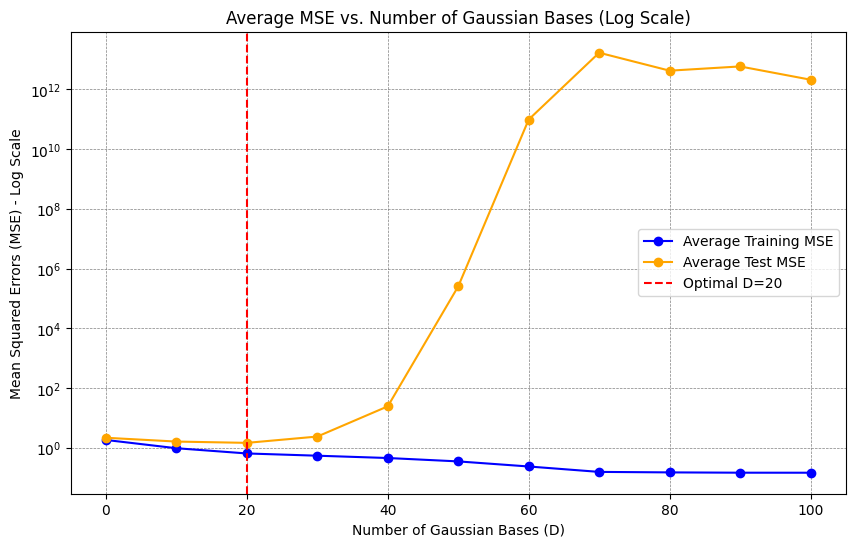

In [61]:
np.random.seed(0)
train_MSE = {d: [] for d in D}
test_MSE = {d: [] for d in D}

for rep in range(n_reps):
    x, y = generate_data(N)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)

    for d in D:
      if d == 0:
        model = LinearRegression()
      else:
        model = GaussianBasisLinearRegression(d)
      model.fit(x_train, y_train)

      # Training error
      yh_train = model.predict(x_train)
      train_MSE[d].append(np.mean((y_train - yh_train) ** 2))
      # Test error
      yh_test = model.predict(x_test)
      test_MSE[d].append(np.mean((y_test - yh_test) ** 2))

# Calculate average training and test SSE for each D value across all repetitions
avg_training_MSE = {d: np.mean(train_MSE[d]) for d in D}
avg_test_MSE = {d: np.mean(test_MSE[d]) for d in D}
optimal_D = min(avg_test_MSE, key=avg_test_MSE.get)

# Plotting the average training and test SSE in log scale
plt.figure(figsize=(10, 6))
plt.semilogy(D, [avg_training_MSE[d] for d in D], label='Average Training MSE', marker='o', color='blue')
plt.semilogy(D, [avg_test_MSE[d] for d in D], label='Average Test MSE', marker='o', color='orange')
plt.axvline(optimal_D, color='r', linestyle='--', label=f'Optimal D={optimal_D}')

plt.title('Average MSE vs. Number of Gaussian Bases (Log Scale)')
plt.xlabel('Number of Gaussian Bases (D)')
plt.ylabel('Mean Squared Errors (MSE) - Log Scale')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

Based on the provided plots, we can observe the following regarding bias and variance in the Gaussian basis linear regression model:

1. Bias-Variance Tradeoff:

As the number of Gaussian bases (D) increases, we see a clear transition from high bias to high variance:

- Low D: The model shows high bias, underfitting the data. It fails to capture the complexity of the true function, resulting in a simple, nearly flat line for D=1.
- Optimal D (around 20): The model achieves a good balance, closely approximating the true function without excessive fluctuations.
- High D (30 and above): The model exhibits high variance, overfitting the data. It starts to capture noise, leading to erratic predictions, especially at the edges of the input range.

2. Training vs. Validation Error:

The log-scale plot of MSE vs. D clearly illustrates the bias-variance tradeoff:

- Training MSE (blue line) consistently decreases as D increases, indicating better fit to training data.
- Validation MSE (orange line) initially decreases, reaches a minimum around D=10, then sharply increases for higher D values.
- The divergence between training and validation MSE for large D values is a classic sign of overfitting.

In conclusion, these plots effectively demonstrate the importance of model selection to balance bias and variance. The optimal model (D=20) provides the best trade-off between fitting the training data and generalizing to new data, highlighting the value of using a validation set to guide model complexity selection.


# Task 3: Regularization with Cross-Validation

Adding regularization

In [12]:
class LinearRegression:
    def __init__(self, add_bias=True, regularization=None, alpha=1.0):
        self.add_bias = add_bias
        self.w = None
        self.regularization = regularization
        self.alpha = alpha

    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x, np.ones(N)])

        if self.regularization is None:
            self.w = np.linalg.lstsq(x, y, rcond=None)[0]
        elif self.regularization == 'l2':
            self.w = self.ridge_regression(x, y)
        elif self.regularization == 'l1':
            self.w = self.lasso_regression(x, y)
        else:
            raise ValueError("Invalid regularization type. Use 'l1', 'l2', or None.")

        return self

    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x, np.ones(N)])
        yh = x @ self.w
        return yh

    def ridge_regression(self, x, y):
        N, M = x.shape
        I = np.eye(M)  # Identity matrix
        if self.add_bias:
            I[-1, -1] = 0  # Don't penalize the intercept

        w = np.linalg.inv(x.T @ x + self.alpha * I) @ (x.T @ y)

        return w

    def lasso_regression(self, x, y, num_iterations=1000, learning_rate=0.01, tolerance=1e-4):
        n, m = x.shape
        w = np.zeros(m)
        for _ in range(num_iterations):
            w_old = w.copy()
            predictions = x @ w
            error = predictions - y
            gradient = (2/n) * (x.T @ error)
            if self.add_bias:
                gradient[:-1] += self.alpha * np.sign(w[:-1])  # Don't penalize the intercept
            else:
                gradient += self.alpha * np.sign(w)
            w -= learning_rate * gradient

            if np.linalg.norm(w - w_old) < tolerance:
                break

        return w

class GaussianBasisLinearRegression(LinearRegression):
    def __init__(self, D, regularization=None, alpha=1.0):
        super().__init__(add_bias=True, regularization=regularization, alpha=alpha)
        self.D = D
        self.mus = None

    def gaussian_basis(self, x, mu, sigma=1):
        return np.exp(-((x - mu) ** 2) / ( sigma ** 2))

    def fit(self, x, y):
        self.mus = np.linspace(min(x), max(x), self.D)
        phi = np.array([self.gaussian_basis(x, mu) for mu in self.mus]).T
        super().fit(phi, y)
        return self

    def predict(self, x):
        phi = np.array([self.gaussian_basis(x, mu) for mu in self.mus]).T
        return super().predict(phi)

Cross-validation

In [1]:
class KFold:
    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def split(self, X):
        n_samples = len(X)
        indices = np.arange(n_samples)

        if self.shuffle:
            if self.random_state is not None:
                np.random.seed(self.random_state)
            np.random.shuffle(indices)

        fold_sizes = np.full(self.n_splits, n_samples // self.n_splits)
        fold_sizes[:n_samples % self.n_splits] += 1
        current = 0

        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            val_indices = indices[start:stop]
            train_indices = np.setdiff1d(indices, val_indices)
            yield train_indices, val_indices
            current = stop

            #yield indices[start:stop]
            #current = stop

Graphing

7


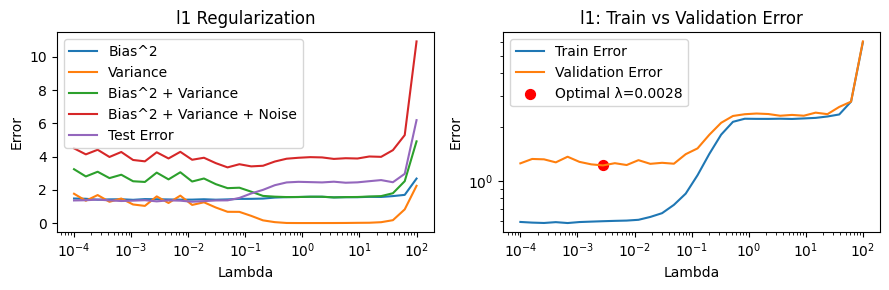

20


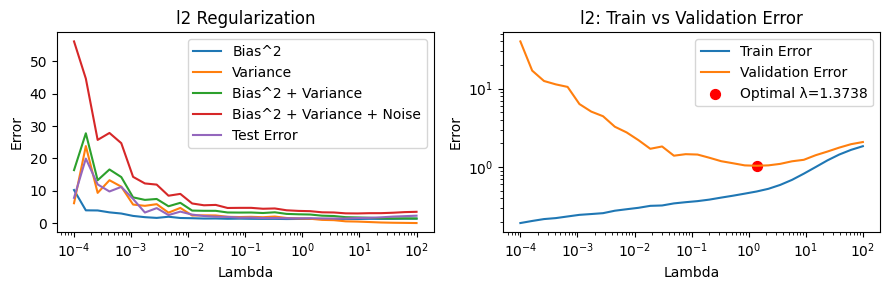

In [55]:
def plot_l1l2_valtest(reg, D = 70, N = 50, lambdas = np.logspace(-4, 2, 30), n_repeat = 10, n_folds = 5):
    train_errors = np.zeros(len(lambdas))
    val_errors = np.zeros(len(lambdas))
    test_errors = np.zeros(len(lambdas))
    bias2 = np.zeros(len(lambdas))
    variance = np.zeros(len(lambdas))

    kf = KFold(n_splits=n_folds, shuffle=True)

    for _ in range(n_repeat):
        x, y = generate_data(N)
        x_test, y_test = generate_data(N)
        #predictions = []

        for i, alpha in enumerate(lambdas):
            train_mse, val_mse = [], []
            bias2_lbd = []
            variance_lbd = []

            for fold, (train_idx, val_idx) in enumerate(kf.split(x)):
                x_train, x_val = x[train_idx], x[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]

                model = GaussianBasisLinearRegression(D = D, regularization = reg, alpha = alpha)
                model.fit(x_train, y_train)

                train_mse.append(np.mean((y_train - model.predict(x_train)) ** 2))
                val_mse.append(np.mean((y_val - model.predict(x_val)) ** 2))
                #fold_predictions.append(model.predict(x_val))

                true_function = np.sin(np.sqrt(x_val)) + np.cos(x_val) + np.sin(x_val)
                pred_mean = np.mean(model.predict(x_val))
                bias2_lbd.append(np.mean((true_function - pred_mean) ** 2))

                predictions = model.predict(x_val)
                variance_lbd = np.mean((predictions - pred_mean) ** 2)

            train_errors[i] += np.mean(train_mse)
            val_errors[i] += np.mean(val_mse)
            bias2[i] += np.mean(bias2_lbd)
            variance[i] += np.mean(variance_lbd)

            y_test_pred = model.predict(x_test)
            test_errors[i] += np.mean((y_test - y_test_pred) ** 2)
    """
            predictions.append(np.concatenate(fold_predictions))

        for i, alpha in enumerate(lambdas):
            mean_prediction = np.mean(predictions[i], axis=0)
            bias2[i] += np.mean((np.sin(np.sqrt(x_val)) + np.cos(x_val) + np.sin(x_val) - mean_prediction) ** 2)
            variance[i] += np.mean(np.var(predictions[i], axis=0))
    """
    train_errors /= n_repeat
    val_errors /= n_repeat
    test_errors /= n_repeat
    bias2 /= n_repeat
    variance /= n_repeat

    optimal_idx = np.argmin(val_errors)
    print(optimal_idx)

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(9, 3))

    # Bias-Variance Analysis
    plt.subplot(1, 2, 1)
    plt.plot(lambdas, bias2, label='Bias^2')
    plt.plot(lambdas, variance, label='Variance')
    plt.plot(lambdas, bias2 + variance, label='Bias^2 + Variance')
    plt.plot(lambdas, bias2 + variance + val_errors, label='Bias^2 + Variance + Noise')
    plt.plot(lambdas, test_errors, label='Test Error')
    plt.xscale('log')
    plt.title(f'{reg} Regularization')
    plt.xlabel('Lambda')
    plt.ylabel('Error')
    plt.legend()

    # Train vs Validation Error
    plt.subplot(1, 2, 2)
    plt.plot(lambdas, train_errors, label='Train Error')
    plt.plot(lambdas, val_errors, label='Validation Error')
    plt.xscale('log')
    plt.yscale('log')
    plt.scatter(lambdas[optimal_idx], val_errors[optimal_idx], color='red', s=50,
                       label=f'Optimal λ={lambdas[optimal_idx]:.4f}')
    plt.title(f'{reg}: Train vs Validation Error')
    plt.xlabel('Lambda')
    plt.ylabel('Error')
    plt.legend()

    plt.tight_layout()
    plt.show()

np.random.seed(SEED)
plot_l1l2_valtest('l1')
plot_l1l2_valtest('l2')

**Effect on Training Error and Validation Error:**

  - For L1, as λ increases, the train error rises sharply. This is because L1 regularization shrinks many weights to zero, simplifying the model, leading to underfitting. For L2, the trainin error increases gradually with λ, but not as sharply as in L1 regularization. This is because L2 regularization shrinks weights without forcing them to zero, maintaining some model flexibility.
  - For L1, the validation error initially decreases, indicating improved generalization. However, after a certain point (around λ ≈ 1), the validation error starts to increase, suggesting that the model becomes too simple and cannot generalize well. As for L2, the validation error initially decreases, then starts to increase after λ ≈ 10⁰, indicating that over-regularization reduces the model's ability to generalize.

**Effect on Bias and Variance:**

  - For L1, variance decreases as λ increases (L1 regularization promotes sparsity, which reduces sensitivity to training data). This behavior is expected because the model becomes less complex. For L2, variance drops consistently with increasing λ, as L2 regularization reduces model complexity by shrinking weights.
  - For L1, bias is relatively stable initially, but increases with very large λ values, as the model becomes too simple and fails to capture important patterns (underfitting). For L2, bias remains relatively stable for smaller λ values but rises sharply after λ ≈ 1, indicating that the model becomes too constrained, leading to underfitting.

**Selecting the Optimal λ for L1:**

  - The optimal λ value balances the tradeoff between low bias and low variance, which corresponds to the point where the validation error is minimized which for L1 is around λ=0.0028 and for L2 is around λ=1.3738


# Task 4: Effect of L1 and L2 Regularization on Loss

Modified linear regression with gradient descent

In [48]:
class GradientDescent:
    def __init__(self, learning_rate=0.01, max_iters=100, epsilon=1e-8, record_history=False):
        self.learning_rate = learning_rate
        self.max_iters = int(max_iters)
        self.epsilon = epsilon
        self.record_history = record_history
        if record_history:
            self.w_history = []  # To record weight history during descent

    def run(self, gradient_fn, x, y, w):
        grad = np.inf  # Initialize gradient to a large value
        t = 1
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            grad = gradient_fn(x, y, w)
            w = w - self.learning_rate * grad
            if self.record_history:
                self.w_history.append(w.copy())
            t += 1
        print("numbers of iterations : ", t)
        print("weight : ", w, "\n\n")
        return w

class LinearRegression:
    def __init__(self, add_bias=True, regularization='l2', alpha=0.1):
        self.add_bias = add_bias
        self.regularization = regularization
        self.alpha = alpha
        self.w = None

    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x, np.ones(N)])
        if self.regularization is None:
            self.w = np.linalg.lstsq(x, y, rcond=None)[0]
        elif self.regularization == 'l2':
            self.w = self.ridge_regression(x, y)
        elif self.regularization == 'l1':
            self.w = self.lasso_regression(x, y)
        else:
            raise ValueError("Invalid regularization type. Use 'l1', 'l2', or None.")
        return self

    def fit_GD(self, x, y, optimizer):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x, np.ones(N)])

        N, D = x.shape
        def gradient(x, y, w):
            predictions = x @ w
            error = predictions - y
            grad = (1 / N) * (x.T @ error)

            if self.regularization == 'l2':
                grad += self.alpha * w
            elif self.regularization == 'l1':
                grad += self.alpha * np.sign(w)
            return grad

        w0 = np.zeros(D)  # Initialize weights
        self.w = optimizer.run(gradient, x, y, w0)  # Run gradient descent
        return self

    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x, np.ones(N)])
        if self.regularization is None:
            self.w = np.linalg.lstsq(x, y, rcond=None)[0]
        elif self.regularization == 'l2':
            self.w = self.ridge_regression(x, y)
        elif self.regularization == 'l1':
            self.w = self.lasso_regression(x, y)
        else:
            raise ValueError("Invalid regularization type. Use 'l1', 'l2', or None.")
        return self

    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x, np.ones(N)])
        return x @ self.w

    def ridge_regression(self, x, y):
        N, M = x.shape
        I = np.eye(M)  # Identity matrix
        if self.add_bias:
            I[-1, -1] = 0  # Don't penalize the intercept
        w = np.linalg.inv(x.T @ x + self.alpha * I) @ (x.T @ y)
        return w

    def lasso_regression(self, x, y, num_iterations=1000, learning_rate=0.01, tolerance=1e-4):
        n, m = x.shape
        w = np.zeros(m)
        for _ in range(num_iterations):
            w_old = w.copy()
            predictions = x @ w
            error = predictions - y
            gradient = (2/n) * (x.T @ error)
            if self.add_bias:
                gradient[:-1] += self.alpha * np.sign(w[:-1])  # Don't penalize the intercept
            else:
                gradient += self.alpha * np.sign(w)
            w -= learning_rate * gradient

            if np.linalg.norm(w - w_old) < tolerance:
                break
        return w

# Define the cost function for visualization
def cost(w, reg, x, y, reg_type='l2'):
    predictions = x @ w
    error = predictions - y
    mse = 0.5 * np.mean(error ** 2)
    if reg_type == 'l2':
        l2_penalty = lambda w: np.dot(w,w)/2
        return mse + reg * l2_penalty(w) #+ reg * np.sum(w[1:] ** 2) / 2 # Exclude bias from penalty
    elif reg_type == 'l1':
        l1_penalty = lambda w: np.sum(np.abs(w))
        return mse + reg * l1_penalty(w) #+ reg * np.sum(np.abs(w[:-1])) / 2 # Exclude bias from penalty

# Contour plot function
def plot_contour(cost_fn, w0_range, w1_range, num_points, ax):
    w0_vals = np.linspace(*w0_range, num_points)
    w1_vals = np.linspace(*w1_range, num_points)
    W0, W1 = np.meshgrid(w0_vals, w1_vals)
    Loss = np.zeros_like(W0)

    for i in range(W0.shape[0]):
        for j in range(W0.shape[1]):
            w = np.array([W1[i, j], W0[i, j]])  # Bias and weight
            Loss[i, j] = cost_fn(w)
    ax.contour(W0, W1, Loss, levels=50, cmap='viridis')

In [49]:
def cross_validate(model_class, X, y, alphas, kf, regularization):
    scores = []
    scores_train = []

    for alpha in alphas:
        model = model_class(regularization = regularization, alpha = alpha, add_bias=False)
        mse_scores = []
        mse_scores_train = []

        for i, (train_index, val_index) in enumerate(kf.split(X)):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            optimizer = GradientDescent(learning_rate=0.01, max_iters=50000, record_history=True)
            model.fit_GD(X_train, y_train, optimizer)
            y_pred = model.predict(X_val)

            mse = np.mean((y_val - y_pred) ** 2)
            mse_scores.append(mse)

            mse_train = np.mean((y_train - model.predict(X_train)) ** 2)
            mse_scores_train.append(mse_train)

        scores.append((alpha, np.mean(mse_scores)))
        scores_train.append((alpha, np.mean(mse_scores_train)))

    return scores , scores_train

Graphing

Lambda =  0.0 4 
Regularization type :  l1
numbers of iterations :  6866
weight :  [-4.04468679 10.19337851] 


Lambda =  0.0 4 
Regularization type :  l2
numbers of iterations :  6866
weight :  [-4.04468679 10.19337851] 


Lambda =  1.0 4 
Regularization type :  l1
numbers of iterations :  6690
weight :  [-3.37717113  6.21676661] 


Lambda =  1.0 4 
Regularization type :  l2
numbers of iterations :  1514
weight :  [-2.64453759  1.97488927] 


Lambda =  3.1622776601683795 4 
Regularization type :  l1
numbers of iterations :  50000
weight :  [-2.316002    0.00773321] 


Lambda =  3.1622776601683795 4 
Regularization type :  l2
numbers of iterations :  559
weight :  [-2.25535535  0.53199764] 


Lambda =  10.0 4 
Regularization type :  l1
numbers of iterations :  50000
weight :  [-2.06892434  0.09146696] 


Lambda =  10.0 4 
Regularization type :  l2
numbers of iterations :  182
weight :  [-1.78932611  0.01238055] 




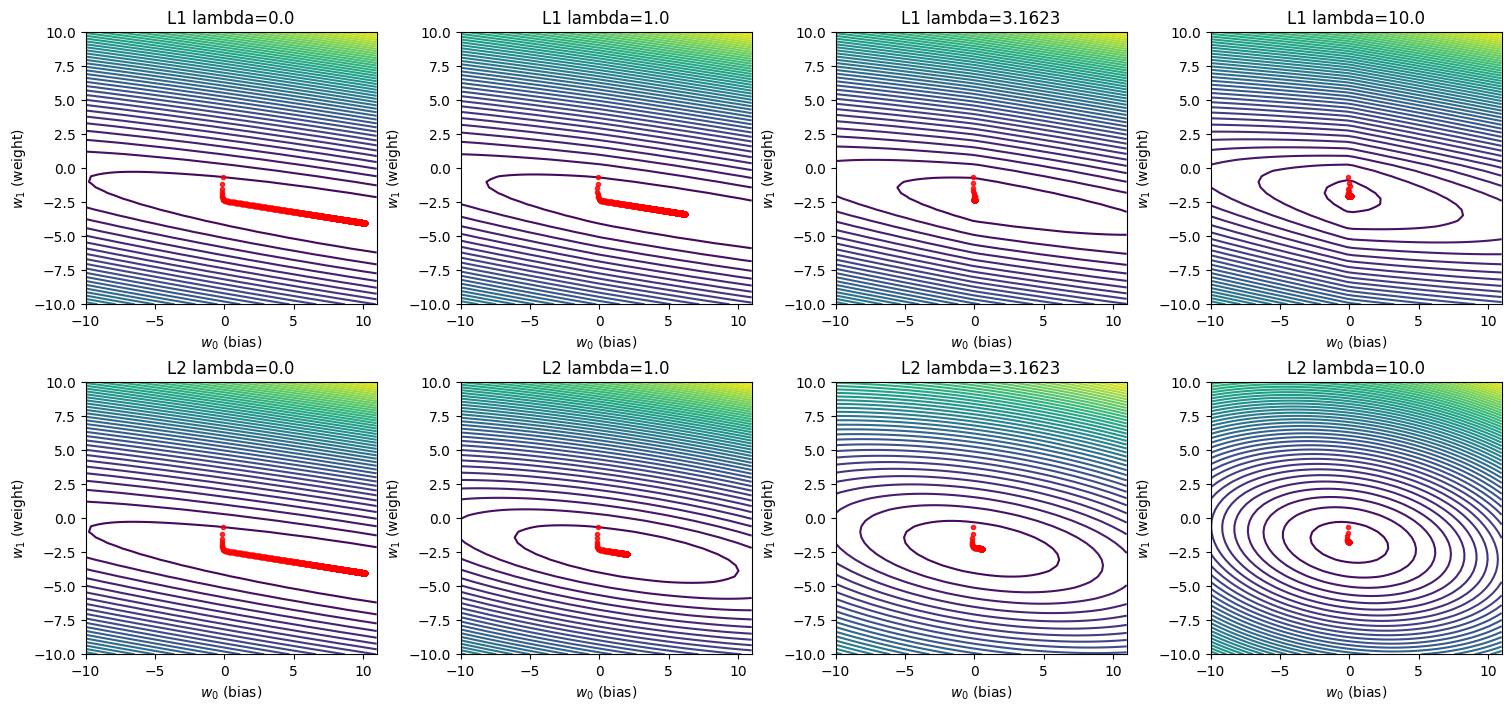

In [50]:
# Generate synthetic data
np.random.seed(42)
x = np.random.uniform(0, 10, 50)
eps = np.random.normal(0, 1, 50)
y = -4 * x + 10 + 2 * eps
X = np.column_stack([x, np.ones(len(x))])

# Regularization coefficients to visualize
reg_list = np.logspace(0,1,3)
reg_list = np.insert(reg_list, 0, 0)

fig, axes = plt.subplots(ncols=len(reg_list), nrows=2, constrained_layout=True, figsize=(15, 7))

for i, reg_coef in enumerate(reg_list):
    for j, reg_type in enumerate(['l1', 'l2']):
        print("Lambda = ",reg_coef,4, "\nRegularization type : ", reg_type)

        # Create optimizer with history recording
        optimizer = GradientDescent(learning_rate=0.01, max_iters=50000, record_history=True)

        # Create and fit model
        model = LinearRegression(regularization=reg_type, alpha=reg_coef)
        model.fit_GD(x, y, optimizer)

        # Define the cost function for plotting
        current_cost = lambda w: cost(w, reg_coef, X, y, reg_type)

        # Plot the loss contour
        plot_contour(current_cost, [-10, 11], [-10, 10], 50, axes[j, i])

        # Plot the gradient descent trajectory
        w_hist = np.vstack(optimizer.w_history)  # Convert history to NumPy array
        axes[j, i].plot(w_hist[:, 1], w_hist[:, 0], '.r', alpha=0.8)  # Plot points

        # Set plot labels and title
        axes[j, i].set_xlabel(r'$w_0$ (bias)')
        axes[j, i].set_ylabel(r'$w_1$ (weight)')
        axes[j, i].set_title(f'{reg_type.upper()} lambda={round(reg_coef,4)}')
plt.show()

numbers of iterations :  6494
weight :  [-4.05520113 10.24696808] 


numbers of iterations :  6947
weight :  [-4.06101376 10.2908398 ] 


numbers of iterations :  6664
weight :  [-3.9966888  10.03275736] 


numbers of iterations :  7287
weight :  [-4.09131697 10.48868868] 


numbers of iterations :  7121
weight :  [-4.01904004  9.89997496] 


numbers of iterations :  6494
weight :  [-4.05513591 10.24656832] 


numbers of iterations :  6947
weight :  [-4.06094386 10.29041063] 


numbers of iterations :  6664
weight :  [-3.99661868 10.03234471] 


numbers of iterations :  7287
weight :  [-4.09123485 10.48823388] 


numbers of iterations :  7121
weight :  [-4.0189672   9.89953304] 


numbers of iterations :  6494
weight :  [-4.05500097 10.24574115] 


numbers of iterations :  6947
weight :  [-4.06079923 10.28952261] 


numbers of iterations :  6664
weight :  [-3.99647358 10.03149088] 


numbers of iterations :  7287
weight :  [-4.09106495 10.48729284] 


numbers of iterations :  7121
weig

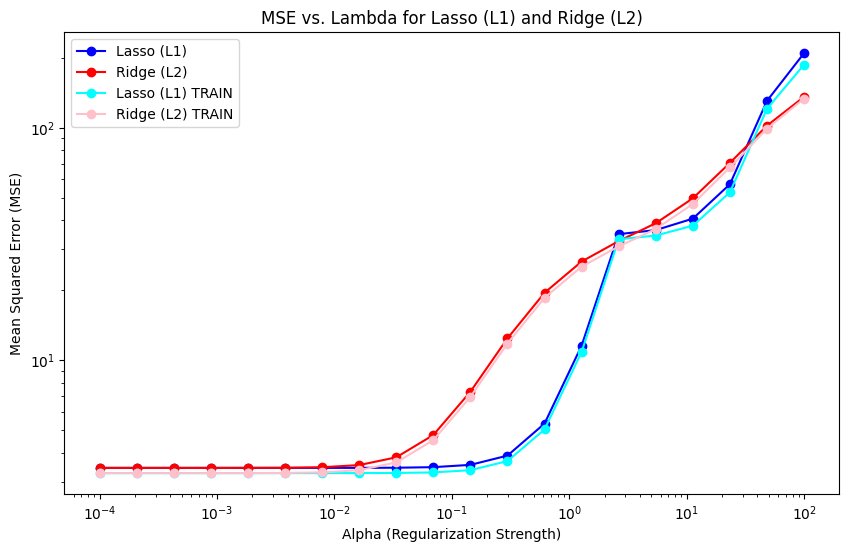

In [51]:
# Generate synthetic data
np.random.seed(SEED)
x = np.random.uniform(0, 10, 50)
eps = np.random.normal(0, 1, 50)
y = -4 * x + 10 + 2 * eps
X = np.column_stack([x, np.ones(len(x))])

alphas = np.logspace(-4, 2, 20)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for L1/L2 regularization
lasso_scores, lasso_score_train = cross_validate(LinearRegression, X, y, alphas, kf, regularization='l1')
ridge_scores, ridge_score_train = cross_validate(LinearRegression, X, y, alphas, kf, regularization='l2')

# Print the results
print("Lasso (L1) Scores:")
for alpha, mse in lasso_scores:
    print(f"Alpha: {alpha:.4f}, MSE: {mse:.4f}")

print("\nRidge (L2) Scores:")
for alpha, mse in ridge_scores:
    print(f"Alpha: {alpha:.4f}, MSE: {mse:.4f}")

plt.figure(figsize=(10, 6))
plt.plot([alpha for alpha, _ in lasso_scores], [mse for _, mse in lasso_scores], label='Lasso (L1)', linestyle='-', marker = 'o', color='blue')
plt.plot([alpha for alpha, _ in ridge_scores], [mse for _, mse in ridge_scores], label='Ridge (L2)', linestyle='-', marker = 'o', color='red')
plt.plot([alpha for alpha, _ in ridge_scores], [mse for _, mse in lasso_score_train], label='Lasso (L1) TRAIN', linestyle='-', marker = 'o', color='cyan')
plt.plot([alpha for alpha, _ in ridge_scores], [mse for _, mse in ridge_score_train], label='Ridge (L2) TRAIN', linestyle='-', marker = 'o', color='pink')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs. Lambda for Lasso (L1) and Ridge (L2)')
plt.legend()
plt.show()

### Observations

- **L1 Regularization**:
  - As λ increases, the **weight \( w_1 \)** shrinks rapidly towards 0.
  - This is useful when we expect only a few features to be relevant (i.e., when we want feature selection).

- **L2 Regularization**:
  - Unlike L1, L2 regularization does not set weights to **exactly 0**. Instead, the weights are **shrunk smoothly towards smaller values**. As \λ increases, both the **bias \( w_0 \)** and the weight \( w_1 \) shrink closer to 0, but they remain non-zero. In other words, L2 shrinks weights uniformly but does not enforce sparsity.
  - Useful when all features are expected to contribute and you want to prevent large coefficients.

- **Regularization Strength**:
  - Regularization is only useful when we need to simplify an overly complex model. However, in our case, since the model is already linear, applying regularization doesn't make much sense.
  - We thus observe an increase in MSE when using regularization as we are simplifying a linear regresion model fitted to linear data.